<a href="https://colab.research.google.com/github/nicktho16/Projects/blob/main/AILearningGameProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

First Game Idea - "Maze Runner" to demonstrate the fundamental concepts of Q-learning.

/usr/local/lib/python3.11/dist-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):



Learned Policy (0=Left, 1=Down, 2=Right, 3=Up):
State 0: Action 0
State 1: Action 0
State 2: Action 0
State 3: Action 0
State 4: Action 0
State 5: Action 0
State 6: Action 0
State 7: Action -1
State 8: Action 0
State 9: Action 0
State 10: Action 0
State 11: Action -1
State 12: Action 0
State 13: Action 0
State 14: Action 0
State 15: Action -1

Final Q-Table:
State 0: [0. 0. 0. 0.]
State 1: [0. 0. 0. 0.]
State 2: [0. 0. 0. 0.]
State 3: [0. 0. 0. 0.]
State 4: [0. 0. 0. 0.]
State 5: [0. 0. 0. 0.]
State 6: [0. 0. 0. 0.]
State 8: [0. 0. 0. 0.]
State 9: [0. 0. 0. 0.]
State 10: [0. 0. 0. 0.]
State 12: [0. 0. 0. 0.]
State 13: [0. 0. 0. 0.]
State 14: [0. 0. 0. 0.]


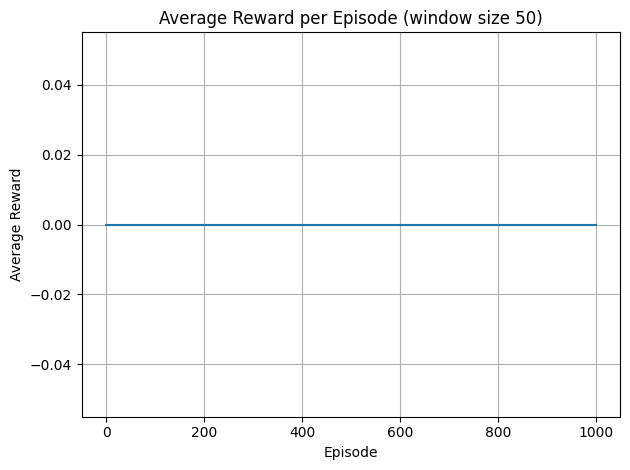

In [ ]:
from IPython import get_ipython
from IPython.display import display

# First Game Idea - "Maze Runner" to demonstrate the fundamental concepts of Q-learning.
# %%
!pip install --upgrade gym>=0.26.0
!pip install --upgrade numpy==1.24.0
import gym
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# Create the FrozenLake environment (4x4, deterministic)
env = gym.make("FrozenLake-v1", is_slippery=False)

# Initialize Q-table
Q = defaultdict(lambda: np.zeros(env.action_space.n))

# Hyperparameters
alpha = 0.8         # Learning rate
gamma = 0.95        # Discount factor
epsilon = 0.1       # Exploration rate
episodes = 1000     # Number of episodes
max_steps = 100     # Max steps per episode

# Track rewards per episode
rewards = []

# Q-Learning algorithm
for episode in range(episodes):
    # env.reset() returns a tuple (observation, info) in newer Gym versions
    state = env.reset()
    # For newer Gym versions, reset() returns a tuple (observation, info).
    # We only need the observation (state).
    if isinstance(state, tuple):
        state = state[0]

    total_reward = 0

    for step in range(max_steps):
        # ε-greedy action selection
        if np.random.rand() < epsilon:
            action = env.action_space.sample()
        else:
            # Ensure state is hashable for defaultdict
            if isinstance(state, np.ndarray):
                state = tuple(state) # Convert numpy array state to tuple if necessary

            action = np.argmax(Q[state])

        # Take action
        # In newer Gym versions, step() returns (observation, reward, terminated, truncated, info)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        # Q-value update
        # Ensure next_state is hashable for defaultdict
        if isinstance(next_state, np.ndarray):
            next_state = tuple(next_state) # Convert numpy array next_state to tuple if necessary

        best_next_action = np.argmax(Q[next_state])
        td_target = reward + gamma * Q[next_state][best_next_action]
        Q[state][action] += alpha * (td_target - Q[state][action])

        state = next_state
        total_reward += reward

        if done:
            break

    rewards.append(total_reward)

# Derive policy from Q-table
policy = {}
for state, actions in Q.items():
     # Ensure state is hashable for policy dictionary
    if isinstance(state, np.ndarray):
        state = tuple(state)

    policy[state] = np.argmax(actions)


# Print learned policy
print("\nLearned Policy (0=Left, 1=Down, 2=Right, 3=Up):")
# FrozenLake states are integers, so we iterate through possible states
for s in range(env.observation_space.n):
    # Use .get() with a default value to handle states not encountered
    action = policy.get(s, -1)
    print(f"State {s}: Action {action}")


# Print final Q-values
print("\nFinal Q-Table:")
# Q keys are already sorted by default for simple int keys, but sorting ensures consistency
for s in sorted(Q.keys()):
    print(f"State {s}: {np.round(Q[s], 2)}")


# Plot rewards
window = 50
avg_rewards = [np.mean(rewards[max(0, i - window):(i + 1)]) for i in range(len(rewards))]

plt.plot(avg_rewards)
plt.title("Average Reward per Episode (window size 50)")
plt.xlabel("Episode")
plt.ylabel("Average Reward")
plt.grid(True)
plt.tight_layout()
plt.show()

env.close()

Second game idea - Monte Carlo Tree Search - Tic-Tac-Toe AI Battle

In [ ]:
import math
import random
from copy import deepcopy

class TicTacToe:
    def __init__(self):
       self.board = [" "] * 9
       self.current_player = "X"

    def available_moves(self):
        return [i for i, spot in enumerate(self.board) if spot == " "]

    def make_move(self, index):
        if self.board[index] == " ":
            self.board[index] = self.current_player
            self.current_player = "O" if self.current_player == "X" else "X"
            return True
        return False

    def winner(self):
        combos = [(0,1,2),(3,4,5),(6,7,8),(0,3,6),(1,4,7),(2,5,8),(0,4,8),(2,4,6)]
        for a,b,c in combos:
            if self.board[a] == self.board[b] == self.board[c] != " ":
                return self.board[a]
        if " " not in self.board:
            return "Tie"
        return None

    def clone(self):
        clone = TicTacToe()
        clone.board = self.board[:]
        clone.current_player = self.current_player
        return clone

# --- MCTS Node ---
class Node:
    def __init__(self, state, parent=None, move=None):
        self.state = state
        self.parent = parent
        self.move = move
        self.children = []
        self.wins = 0
        self.visits = 0

    def expand(self):
        for move in self.state.available_moves():
            next_state = self.state.clone()
            next_state.make_move(move)
            self.children.append(Node(next_state, self, move))

    def is_fully_expanded(self):
        return len(self.children) == len(self.state.available_moves())

    def best_child(self, c_param=1.41):
        choices = [(child, (child.wins / child.visits) + c_param * math.sqrt(math.log(self.visits) / child.visits))
                   for child in self.children if child.visits > 0]
        return max(choices, key=lambda x: x[1])[0] if choices else random.choice(self.children)

    def backpropagate(self, result):
        self.visits += 1
        if result == self.state.current_player:
            self.wins += 1
        elif result == "Tie":
            self.wins += 0.5
        if self.parent:
            self.parent.backpropagate(result)

# --- MCTS Function ---
def mcts(root, iterations=1000):
    for _ in range(iterations):
        node = root
        while node.children:
            node = node.best_child()
        if not node.state.winner():
            node.expand()
            if node.children:
                node = random.choice(node.children)
        result = node.state.winner()
        if result:
            node.backpropagate(result)
    return root.best_child(c_param=0)  # Greedy best

# --- Simulate game ---
def play_mcts_vs_random():
    game = TicTacToe()
    while not game.winner():
        if game.current_player == "X":
            root = Node(game.clone())
            move = mcts(root, 500).move
            game.make_move(move)
        else:
            move = random.choice(game.available_moves())
            game.make_move(move)
        print_board(game.board)
    print(f"Game over! Winner: {game.winner()}")

def print_board(board):
    print("\n")
    for i in range(0, 9, 3):
        print(" | ".join(board[i:i+3]))
        if i < 6:
            print("---------")

# Run a demo
debug = __name__ == "__main__"
if debug:
    play_mcts_vs_random()





X |   |  
---------
  |   |  
---------
  |   |  


X | O |  
---------
  |   |  
---------
  |   |  


X | O |  
---------
  | X |  
---------
  |   |  


X | O |  
---------
  | X |  
---------
O |   |  


X | O |  
---------
  | X |  
---------
O |   | X
Game over! Winner: X


3rd game idea - SARSA - grid world treasure hunt

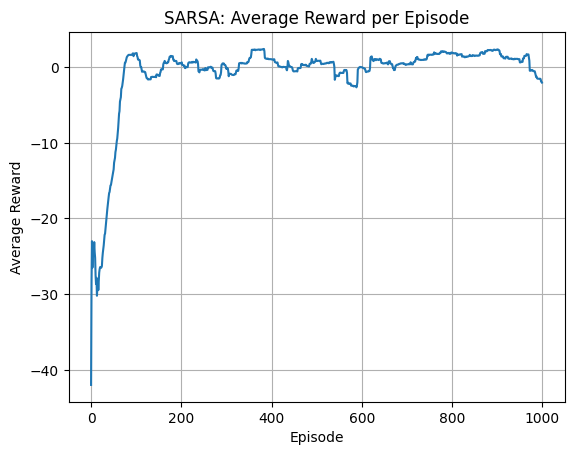

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import defaultdict

class GridWorld:
    # Corrected indentation for the __init__ method
    def __init__(self, size=5, goal=(4, 4), traps=[(1, 1), (2, 3), (3, 2)]):
        self.size = size
        self.goal = goal
        self.traps = traps
        self.reset()

    # Corrected indentation for the reset method
    def reset(self):
        self.agent_pos = (0, 0)
        return self.agent_pos

    # Corrected indentation for the step method
    def step(self, action):
        x, y = self.agent_pos
        if action == 0: y = max(0, y - 1)  # up
        elif action == 1: x = min(self.size - 1, x + 1)  # right
        elif action == 2: y = min(self.size - 1, y + 1)  # down
        elif action == 3: x = max(0, x - 1)  # left

        self.agent_pos = (x, y)

        if self.agent_pos == self.goal:
            return self.agent_pos, 10, True
        elif self.agent_pos in self.traps:
            return self.agent_pos, -10, True
        else:
            return self.agent_pos, -1, False

    # Corrected indentation for the get_state method
    def get_state(self):
        return self.agent_pos

    # Corrected indentation for the get_actions method
    def get_actions(self):
        return [0, 1, 2, 3]  # up, right, down, left

# SARSA Algorithm
class SARSAAgent:
    def __init__(self, env, alpha=0.5, gamma=0.9, epsilon=0.1):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.Q = defaultdict(lambda: np.zeros(4))  # 4 actions

    def choose_action(self, state):
        if random.random() < self.epsilon:
            return random.choice(self.env.get_actions())
        return np.argmax(self.Q[state])

    def learn(self, episodes=1000):
        rewards = []
        for _ in range(episodes):
            state = self.env.reset()
            action = self.choose_action(state)
            total_reward = 0
            done = False

            while not done:
                next_state, reward, done = self.env.step(action)
                next_action = self.choose_action(next_state)

                predict = self.Q[state][action]
                target = reward + self.gamma * self.Q[next_state][next_action]
                self.Q[state][action] += self.alpha * (target - predict)

                state = next_state
                action = next_action
                total_reward += reward

            rewards.append(total_reward)
        return rewards

# Visualization of Training
def visualize_rewards(rewards, window=50):
    avg_rewards = [np.mean(rewards[max(0, i - window):(i + 1)]) for i in range(len(rewards))]
    plt.plot(avg_rewards)
    plt.title("SARSA: Average Reward per Episode")
    plt.xlabel("Episode")
    plt.ylabel("Average Reward")
    plt.grid(True)
    plt.show()

# Run training
env = GridWorld()
agent = SARSAAgent(env)
rewards = agent.learn(1000)
visualize_rewards(rewards)